In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

## Fetching the Data

In [2]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

## Data Fusion TEDS-A + CTN 27

In [3]:
ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

ct94_cc = ct94[common_cols].drop(columns=["edu", "mar"])
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0
# ct94_cc["mar"].loc[(1 - ct94_cc["mar"].isna()) == 1] = (ct94_cc["mar"] == 1.0).astype(
#     int
# )
# ct94_cc["edu"].loc[(1 - ct94_cc["edu"].isna()) == 1] = (ct94_cc["edu"] >= 2.0).astype(
#     int
# )

imputer = KNNImputer(n_neighbors=4, weights="distance", add_indicator=False)
ct94_cc_imputed = imputer.fit_transform(ct94_cc)

ct94_cc = pd.DataFrame(ct94_cc_imputed, index=ct94_cc.index, columns=ct94_cc.columns)

ct94_cc["med_met"] = (ct94[treatment_col] == "met").astype(
    int
)  # methadone = 1 and bupenorphine = 0
ct94_cc = ct94_cc.dropna()

ct94_cc["S"] = 1
ct94_cc = ct94_cc.round(0).astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")
print(ct94_cc.shape)
ct94_cc.groupby(by="med_met").mean()[outcome_cols]

(1271, 11)


,opioiduse12,opioiduse24
med_met,,
0,0.629380,0.750674
1,0.553875,0.650284


In [4]:
df_tedsa_cc = df_tedsa[common_cols].drop(columns=["edu", "mar"])
df_tedsa_cc["S"] = 0
# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

# df_tedsa_cc["mar"].loc[(1 - df_tedsa_cc["mar"].isna()) == 1] = (
#     df_tedsa_cc["mar"] == 1.0
# ).astype(int)
# df_tedsa_cc["edu"].loc[(1 - df_tedsa_cc["edu"].isna()) == 1] = (
#     df_tedsa_cc["edu"] >= 2.0
# ).astype(int)

In [5]:
df_primary = pd.concat([df_tedsa_cc.sample(frac=1, replace=False), ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

In [6]:
outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace"])
data_dummy.rename(
    columns={
        "sex": "Male",
        "age": "Age",
        "ivdrug": "IV Drug Use",
        "bamphetamine30_base": "Hx Amphetamine",
        "bbenzo30_base": "Hx Benzo",
        "bcannabis30_base": "Hx Cannabis",
        "xrace_1": "White",
        "xrace_2": "Black",
        "xrace_3": "Hispanic",
        "xrace_4": "Other Race",
        # "mar": "Married",
        # "edu": "Education(12y)",
    },
    inplace=True,
)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

latex_table = data_dummy.groupby(by=[sample]).mean().T.round(4).to_latex()

## Estimate RCT-ATE and Target-ATE

In [7]:
importlib.reload(learn)
df_v, pi, pi_m, e_m, data2 = learn.estimate_dml(data_dummy, outcome, treatment, sample)

In [8]:
df_v["te_sq"].mean(), df_v["a_sq"].mean()

(2.78182229878656, 2.838288483196468)

In [9]:
print(
    "RCT-ATE: %.2f ± %.2f"
    % (
        100
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
            - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean()
        ),
        100
        * 1.96
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)


print(
    "Transported ATE: %.2f ± %.2f"
    % (100 * df_v["te"].mean(), 1.96 * 100 * df_v["te"].sem())
)

RCT-ATE: -10.04 ± 7.18
Transported ATE: -9.72 ± 9.17


## Characterizing Underrepresented Population via Selection Score

In [10]:
np.random.seed(42)
data_dummy_logit = data_dummy.copy(deep=True)
data_dummy_logit["pi(x)"] = pi_m.predict_proba(X)[:, 1]
# exp_te_m = en.AdaBoostRegressor().fit(data2[X.drop(columns=["Age"]).columns], df_v["a"])

Text(0.5, 0, '$\\ell(x)/\\overline{\\ell}$')

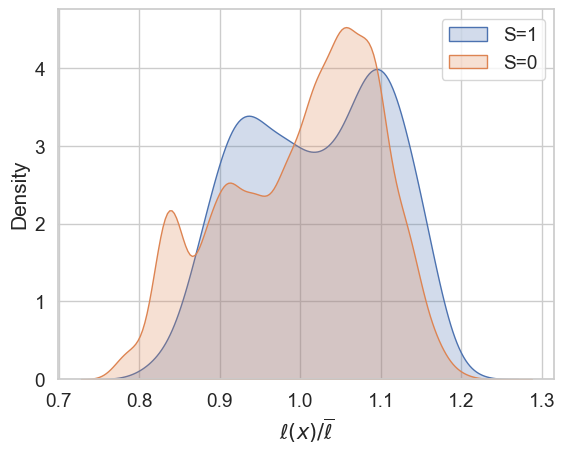

In [11]:
sns.kdeplot(
    (data_dummy_logit["pi(x)"].loc[S == 1] / S.mean())
    / ((1 - data_dummy_logit["pi(x)"].loc[S == 1]) / (1 - S.mean())),
    fill=True,
)
sns.kdeplot(
    (data_dummy_logit["pi(x)"].loc[S == 0] / S.mean())
    / ((1 - data_dummy_logit["pi(x)"].loc[S == 0]) / (1 - S.mean())),
    bw=0.15,
    fill=True,
)
# sns.kdeplot(data_dummy_logit["pi(x)"].loc[S == 0] / S.mean(), bw=0.15, fill=True)

plt.legend(["S=1", "S=0"])
plt.xlabel(r"$\ell(x)/\overline{\ell}$")

In [12]:
data_dummy_logit = data_dummy_logit.drop(columns=X.columns, errors="ignore")
data_dummy_logit.mean()

S              0.001715
med_met        0.000714
opioiduse24    0.001215
pi(x)          0.001715
dtype: float64

In [13]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
np.random.seed(402)
D_labels, f, testing_data = learn.kmeans_opt(
    data=data_dummy_logit,
    outcome=outcome,
    k=500,
    treatment=treatment,
    sample=sample,
    threshold=1,
)

(1271, 1)
(-0.2394255618118667, 0.04692493994260897, -0.1003902391608878, 0.047254950026784454)


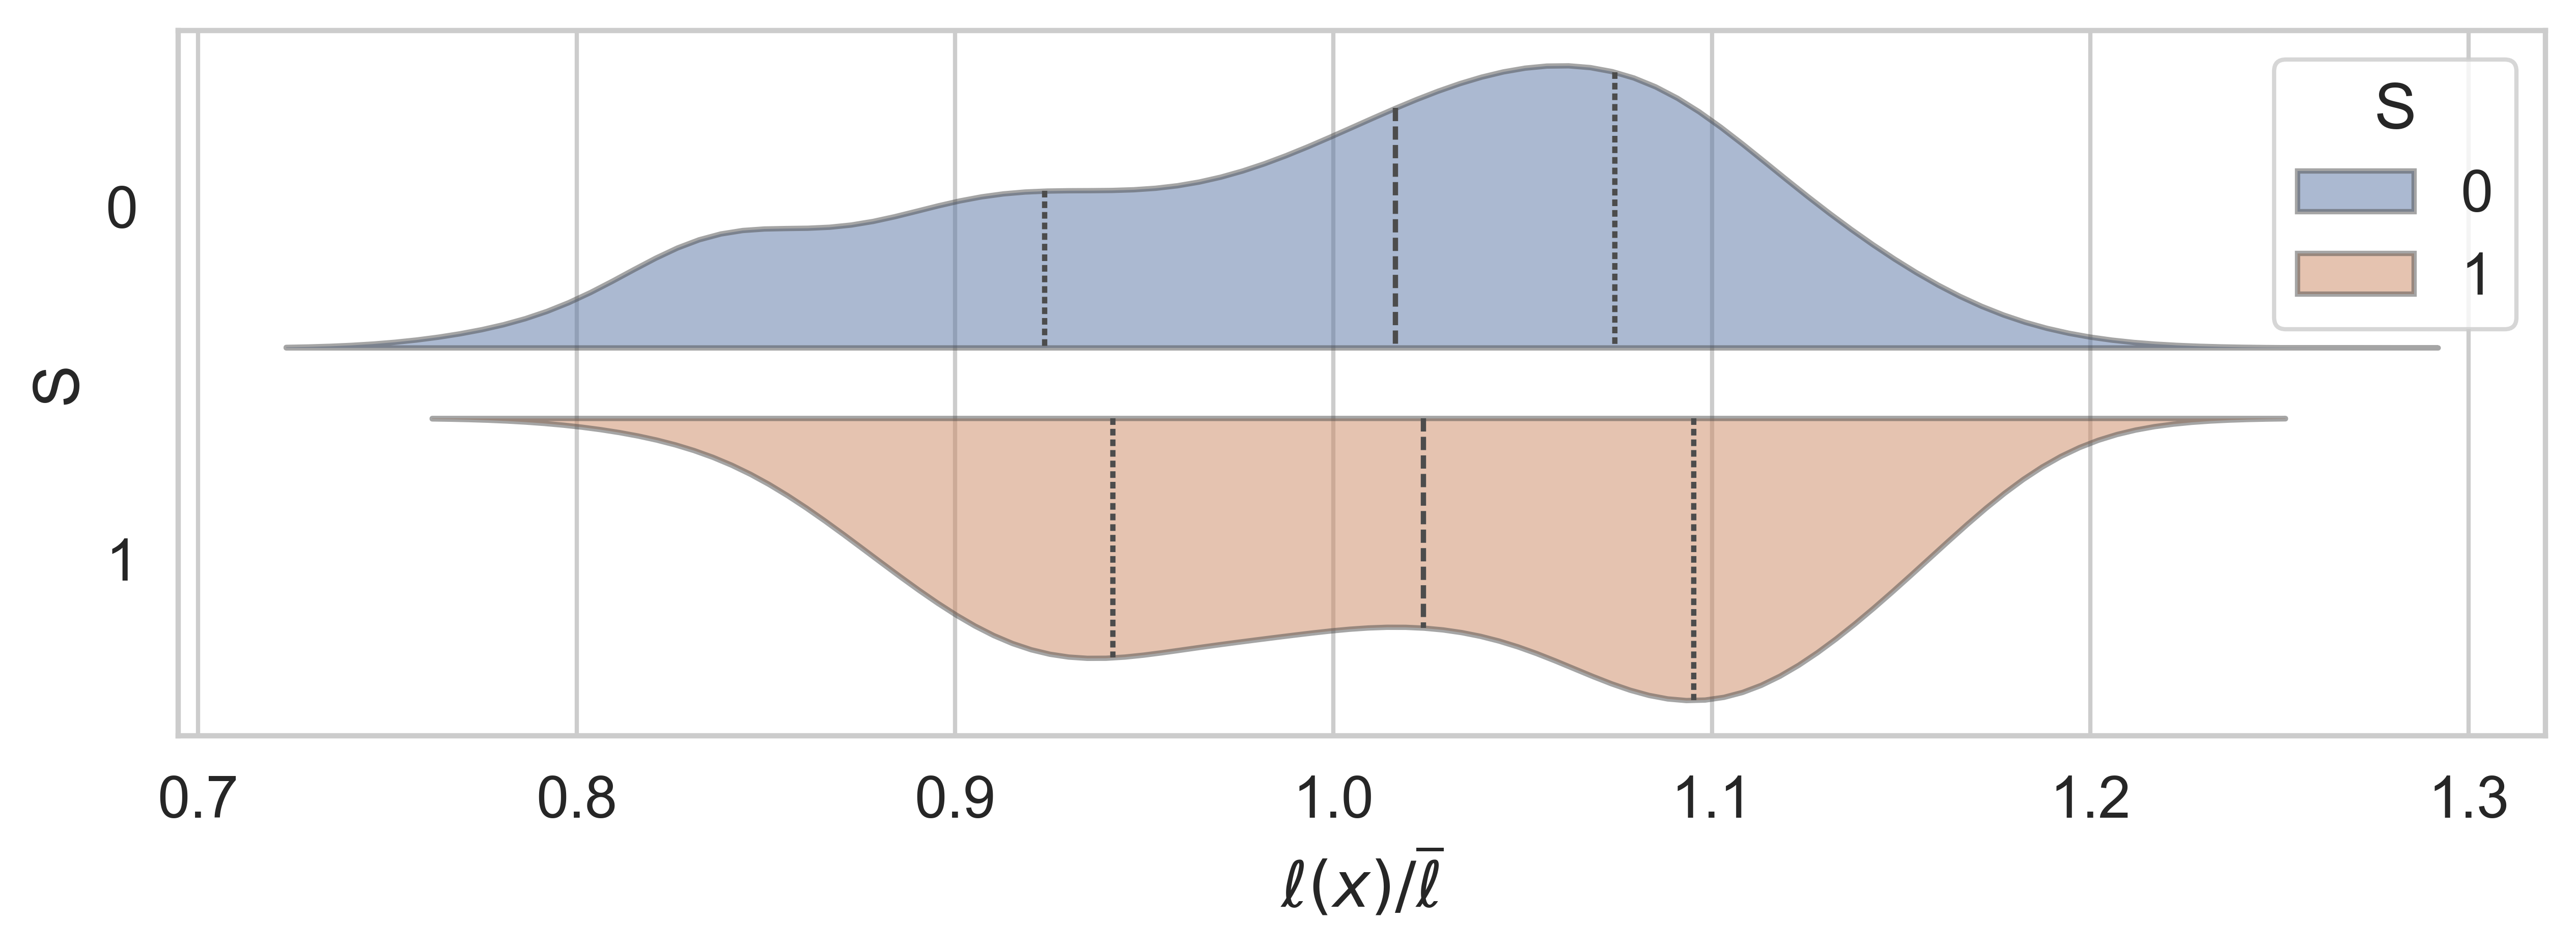

In [23]:
data_dummy_logit["pi(x)/pi"] = data_dummy_logit["pi(x)"] / data_dummy_logit["S"].mean()
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="S",
    hue="S",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
)
plt.xlabel(r"$\ell(x)/\overline{\ell}$")
plt.savefig("selection_logit.pdf")

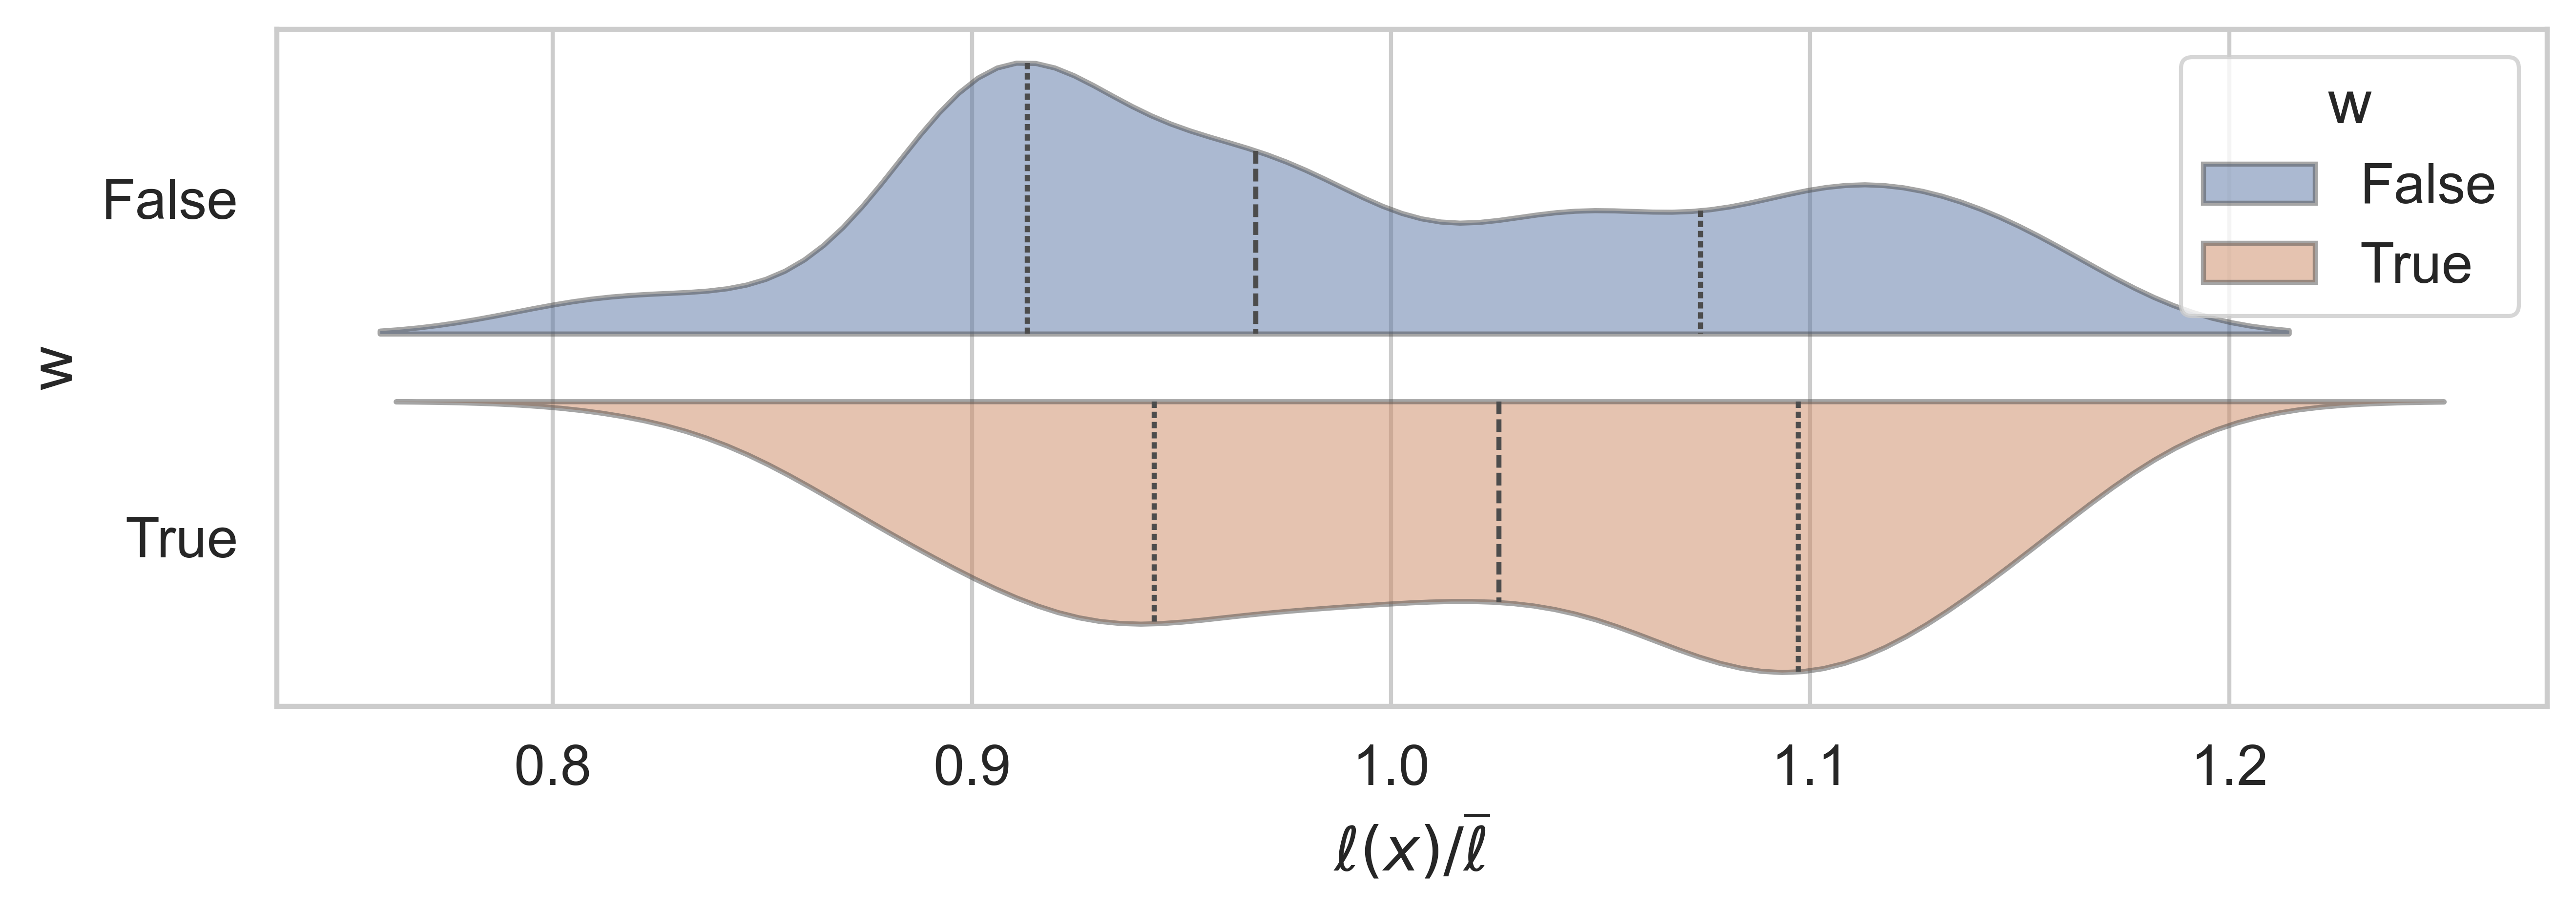

In [24]:
data_dummy_logit["w"] = D_labels["w"]

fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.violinplot(
    data=data_dummy_logit,
    x="pi(x)/pi",
    y="w",
    hue="w",
    split=True,
    orient="h",
    ax=ax,
    alpha=0.5,
    inner="quart",
    bw=0.25,
)

plt.xlabel(r"$\ell(x)/\overline{\ell}$")
plt.savefig("underrep_logit.pdf")

In [15]:
print(
    r"Pre Pruning, ATTE: %.3f ± %.3f"
    % (
        100 * D_labels["v"].mean(),
        100
        * 1.96
        * np.sqrt(D_labels["vsq"].sum() / ((D_labels["w"].astype(int).count()) ** 2)),
    )
)

print(
    r"Post Pruning, ATTE: %.3f ± %.3f"
    % (
        100 * D_labels["v"].loc[D_labels["w"] == 1].mean(),
        100
        * 1.96
        * np.sqrt(
            D_labels["vsq"].loc[D_labels["w"] == 1].sum()
            / ((D_labels["w"].astype(int).sum()) ** 2)
        ),
    )
)

Pre Pruning, ATTE: -10.039 ± 9.262
Post Pruning, ATTE: -23.943 ± 9.197


## Characterizing Underrepresented Population via ROOT

In [16]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
np.random.seed(42)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=0.5,
    num_trees=5000,
    vote_threshold=8 / 10,
    # top_k_trees=True,
    # k=5,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
# print("Baseline Objective:%.4f" % (baseline_loss))

ATE Est: -0.0972
leaf              0.333333
Hx Cannabis       0.083149
Age               0.006037
Hx Amphetamine    0.082013
Male              0.032554
Hx Benzo          0.053123
IV Drug Use       0.133749
White             0.094114
Black             0.126179
Hispanic          0.043907
Other Race        0.011842
dtype: float64


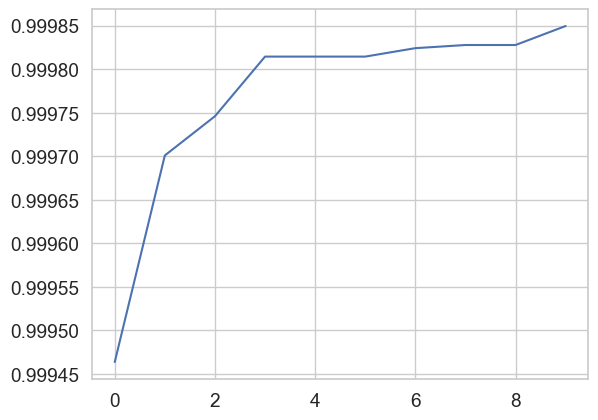

In [17]:
local_obj = pd.DataFrame(
    np.array([w_forest[i]["local objective"] for i in range(len(w_forest))]),
    columns=["Objective"],
).sort_values(by="Objective")

top_k = 10
plt.plot((local_obj.iloc[:top_k] / baseline_loss)["Objective"].values)

In [18]:
w_rash = [
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if i in list(local_obj.iloc[:top_k].index)
]
avg_votes = (D_forest[w_rash].mean(axis=1) >= 0.99).astype(int)
D_rash["w_opt"] = avg_votes

np.random.seed(42)
num_trees = 1
explainer = tree.DecisionTreeClassifier().fit(X.loc[avg_votes.index], avg_votes)

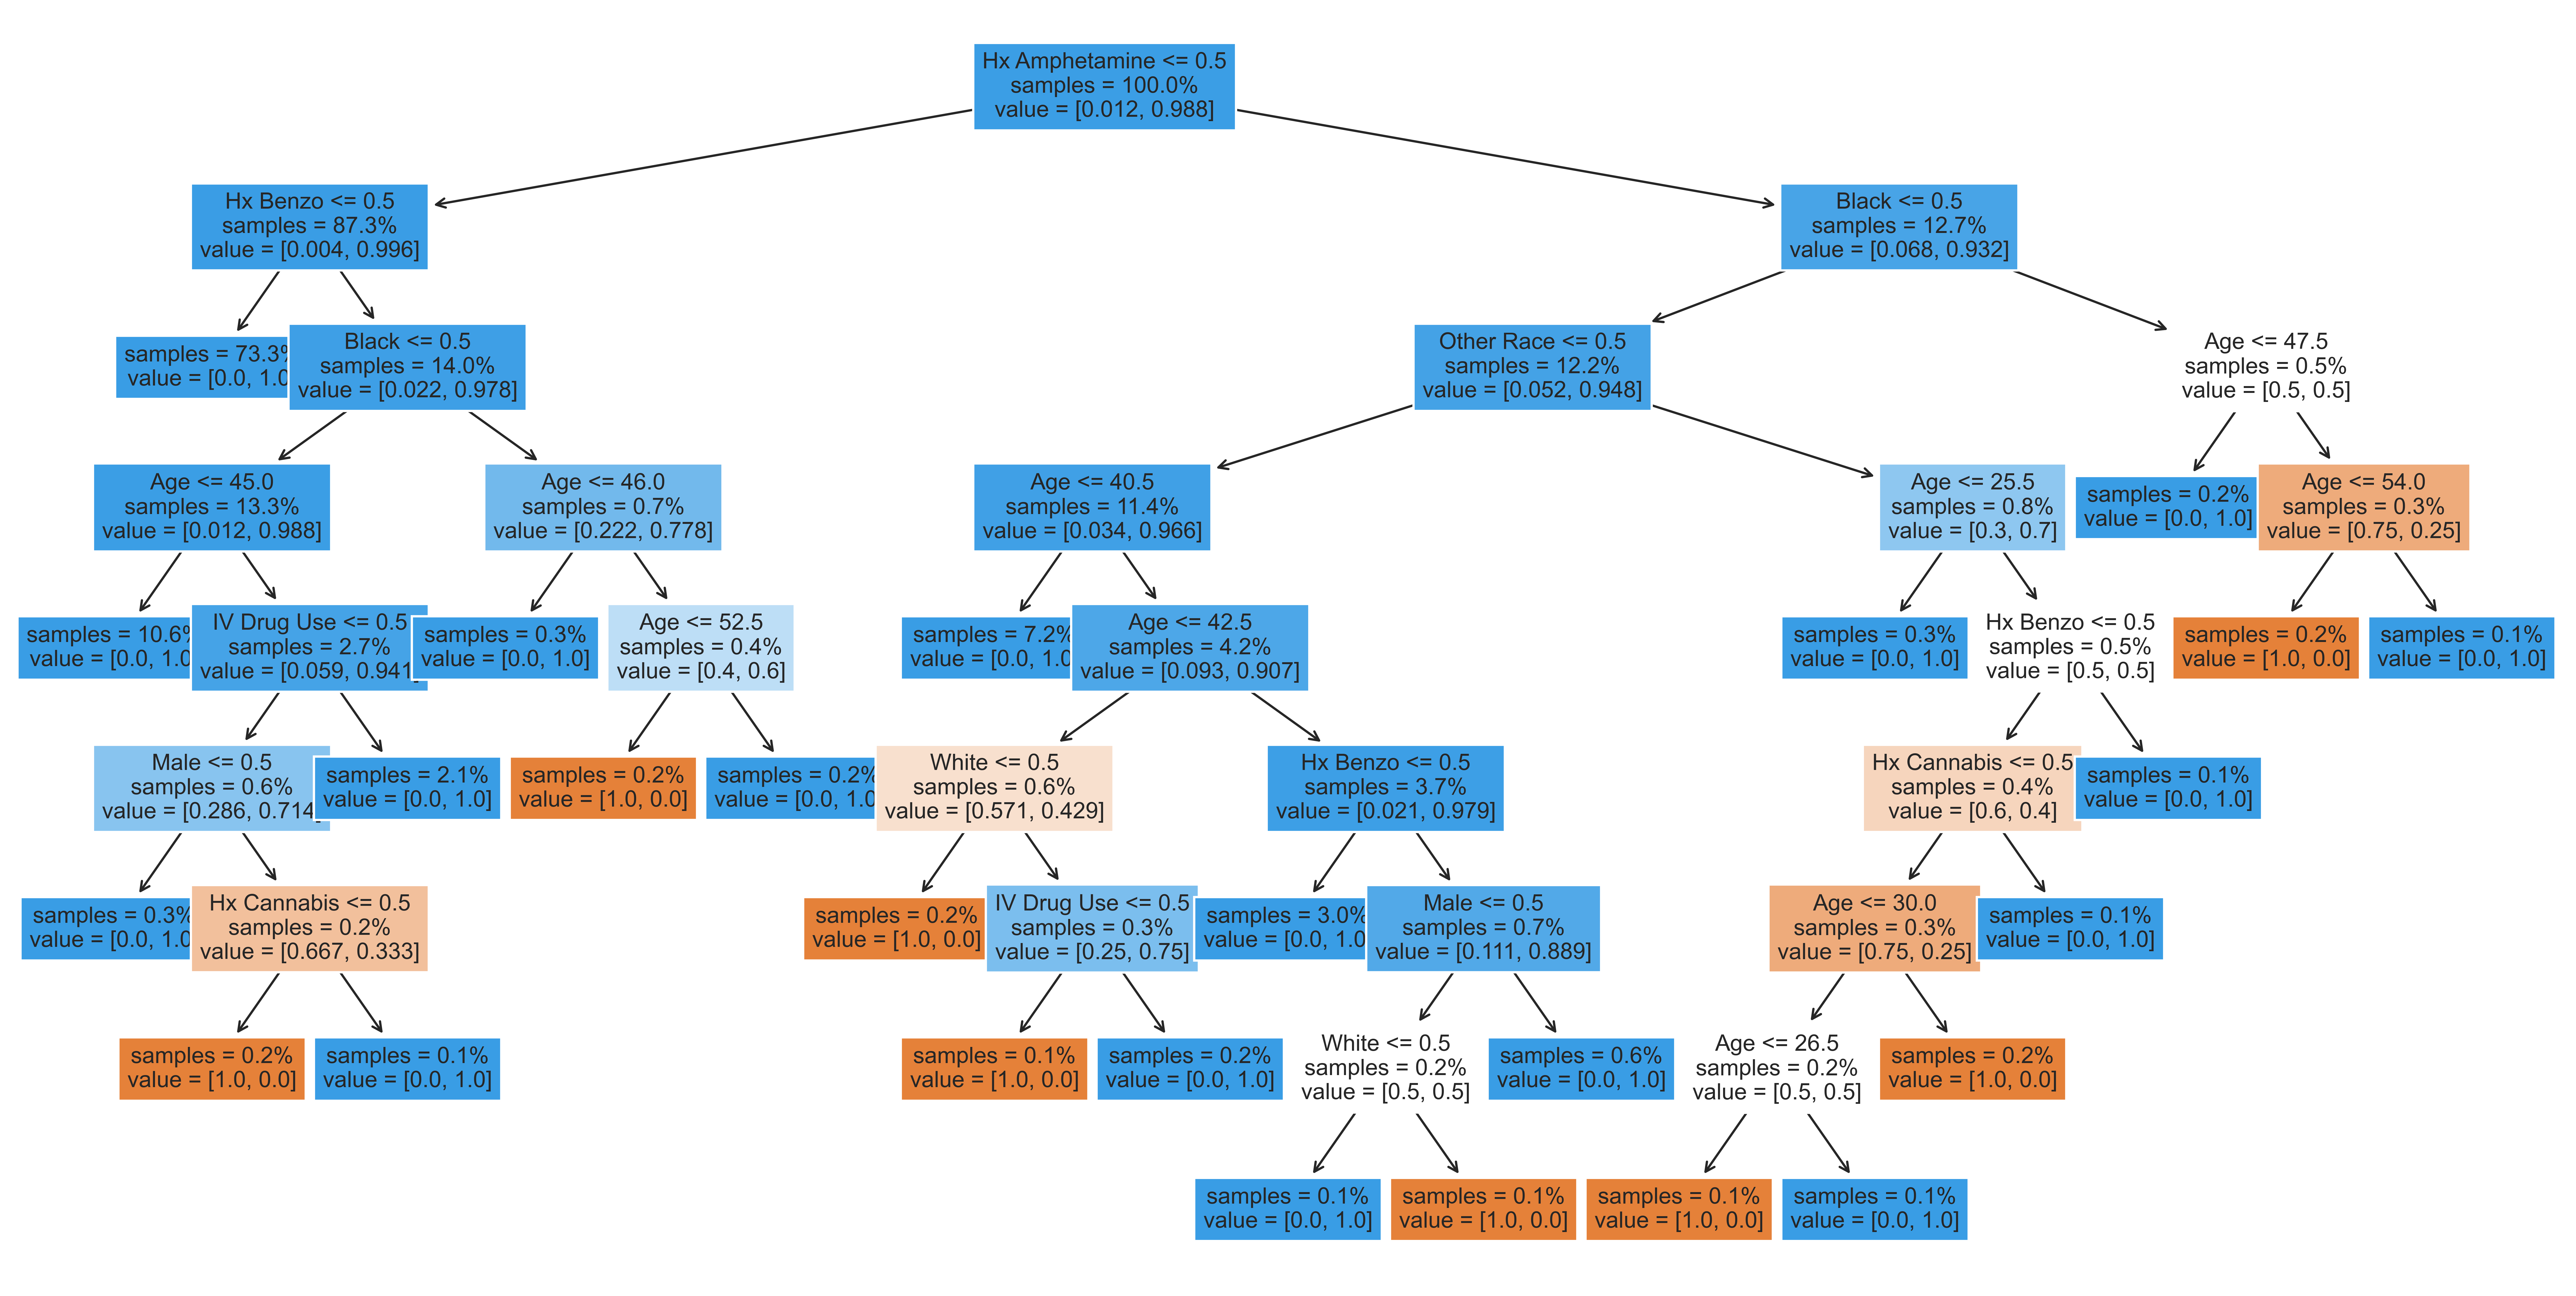

In [19]:
fig, ax = plt.subplots(nrows=num_trees, figsize=(20, 10), dpi=600)
for i in range(num_trees):
    if num_trees == 1:
        tree.plot_tree(
            explainer,  # .estimators_[i, 0],
            feature_names=X.columns,
            ax=ax,
            filled=True,
            fontsize=10,
            proportion=True,
            impurity=False,
        )
    else:
        tree.plot_tree(
            explainer.estimators_[i, 0],
            feature_names=X.columns,
            ax=ax[i],
            filled=True,
            fontsize=10,
            proportion=True,
        )
plt.savefig("tedsa_ctn27.pdf", dpi=600)

In [20]:
w = explainer.predict(data_dummy[X.columns])
data_dummy["w"] = w

pd.concat(
    [
        data_dummy.groupby(by="S").mean().T.round(4),
        data_dummy.loc[data_dummy["w"] == 1].groupby(by="S").mean().T.round(4),
    ],
    axis=1,
)

S,0,1,0,1
Hx Cannabis,0.1147,0.2864,0.1156,0.2898
Age,38.0700,36.8812,37.9951,36.7898
Hx Amphetamine,0.0665,0.1267,0.0615,0.1194
Male,0.5842,0.6774,0.5834,0.6768
Hx Benzo,0.0561,0.1660,0.0526,0.1640
IV Drug Use,0.5376,0.6994,0.5388,0.6998
med_met,0.0000,0.4162,0.0000,0.4108
opioiduse24,0.0000,0.7089,0.0000,0.7054
White,0.6548,0.6758,0.6585,0.6807
Black,0.1487,0.0858,0.1484,0.0828


In [21]:
D_rash["w_opt"] = explainer.predict(X.loc[avg_votes.index])
print(
    r"Post Pruning, ATTE: %.2f ± %.4f"
    % (
        100 * D_rash["v"].loc[D_rash["w_opt"].astype(int) == 1].mean(),
        100 * 1.96 * D_rash["v"].loc[D_rash["w_opt"].astype(int) == 1].sem(),
    )
)

Post Pruning, ATTE: -12.13 ± 9.1565


(-0.12133455760129695, 1.920057133003939)


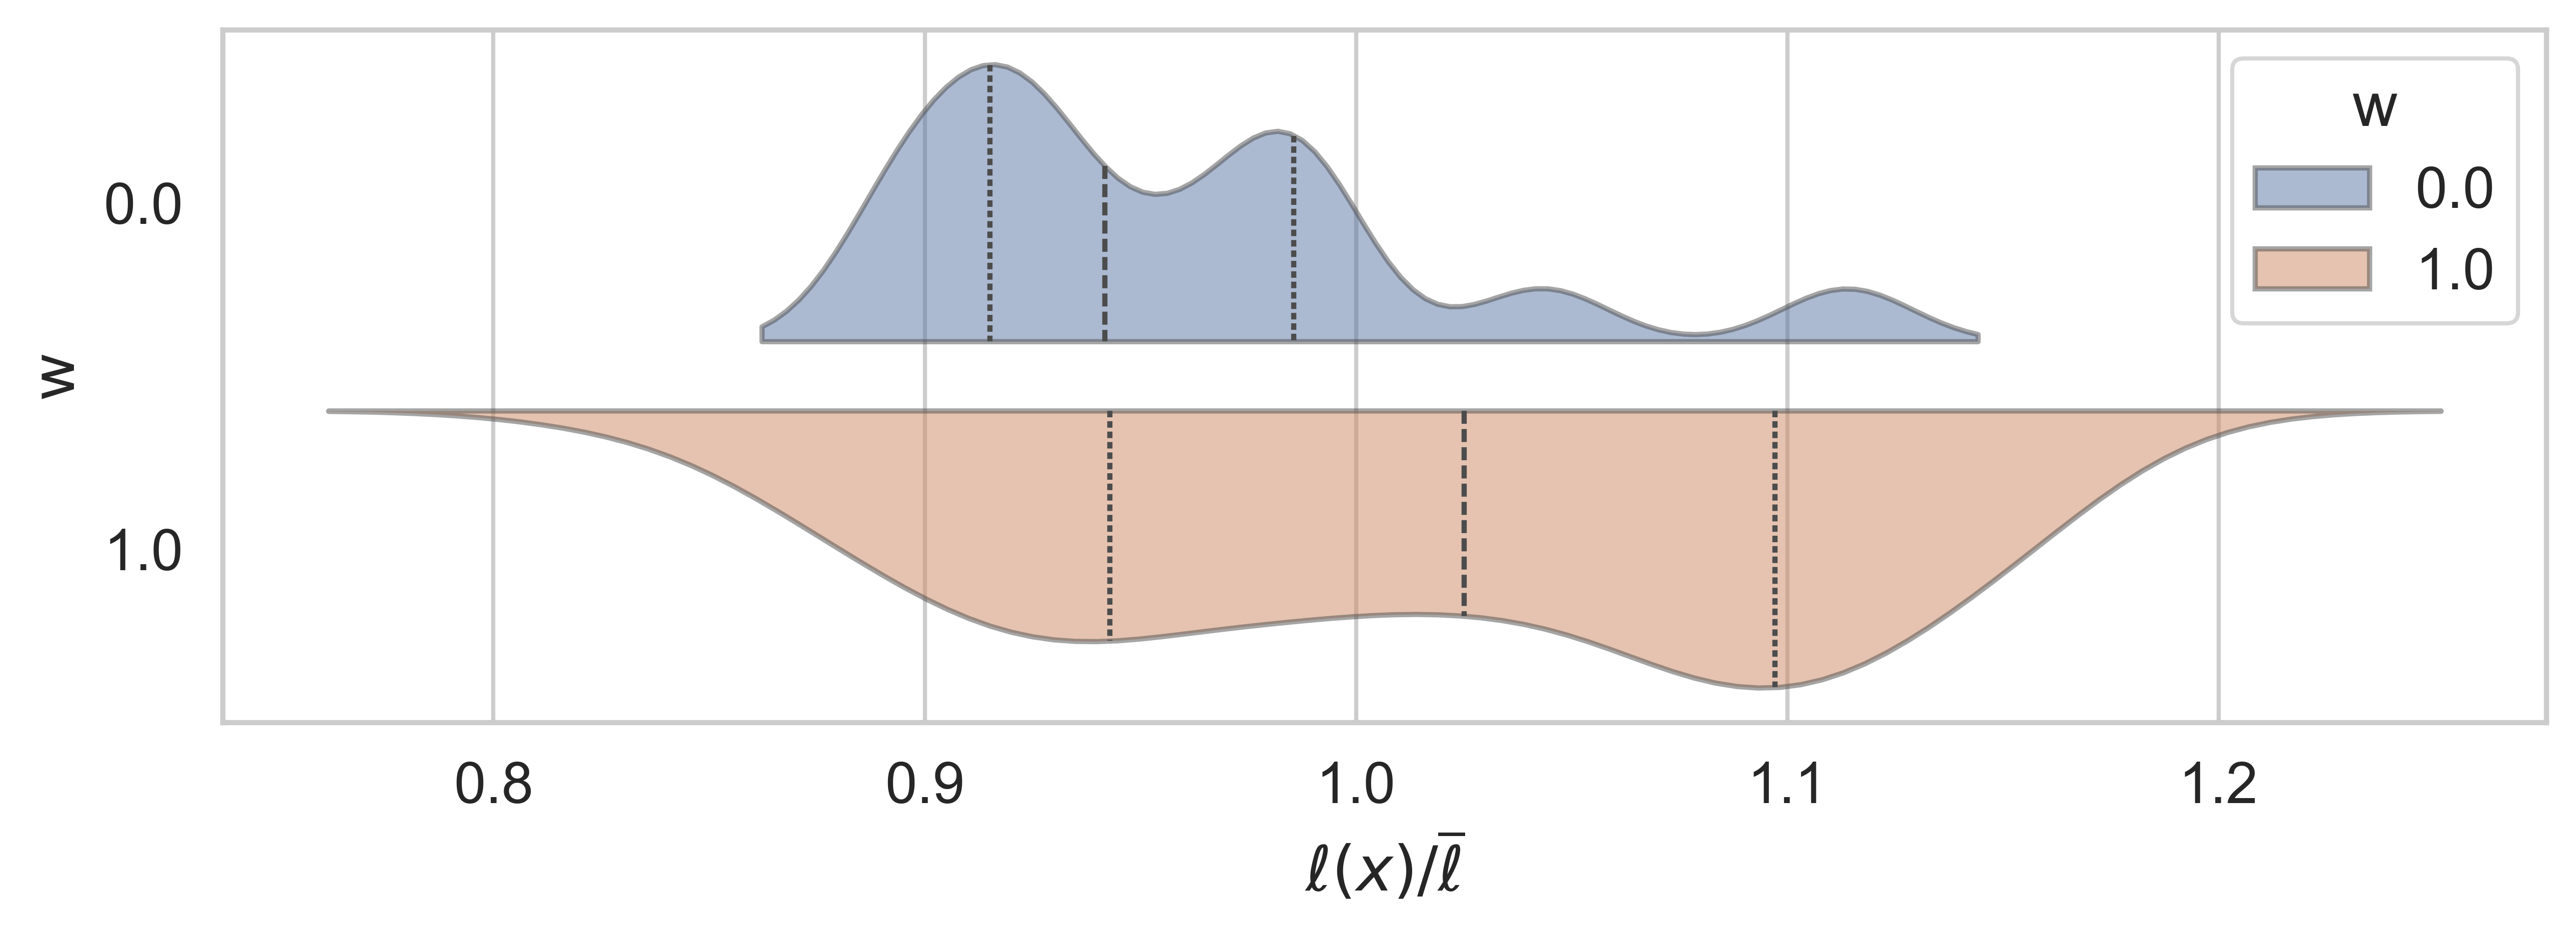

In [22]:
data_dummy_logit["w"] = D_rash["w_opt"]
fig, ax = plt.subplots(sharex=True, figsize=(10, 3), dpi=600)
sns.violinplot(
    data=data_dummy_logit,
    y="w",
    hue="w",
    x="pi(x)/pi",
    orient="h",
    split=True,
    alpha=0.5,
    ax=ax,
    bw=0.25,
    inner="quart",
)
plt.ylabel("w")
plt.legend(title="w")
plt.xlabel(r"$\ell(x)/\overline{\ell}$")
plt.savefig("underrep_root.pdf")


print(
    (
        D_rash.loc[D_rash["w_opt"] == 1]["v"].mean(),
        D_rash.loc[D_rash["w_opt"] == 0]["v"].mean(),
    )
)